In [88]:
import geopandas as gpd
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from topojson import Topology
import json

## Shape files from US Census Dataset

- Shape files are a type of geospatial data format that can be used in geographic information system (GIS) software. 
- Using GeoPandas we can generate exploratory data visualizations of the maps, or process data and export geojson files for explanetory data visualziations.<br>
 **Link to US Census Shape Files:**<br>
https://www.census.gov/cgi-bin/geo/shapefiles/index.php

# Part 1 - Linear data (1D)

## Example: 
The Massachusetts roads shape file is downloaded/loaded in the following cell
<br>
The meta data is as below:<br>
LINEARID: uniquely identify and reference individual road segments, streets, or other linear features

MTFCC: Features of the road

- S1100: Primary Road
- S1200: Secondary Road
- S1400: Local, Neighborhood, or Rural Road

RTTYP: is Route Type:
- C: County or parish road
- I: Interstate highway
- M: Commonly used for main or major roads
- O: Other road types (varies by dataset)
- S: State highway
- U: U.S. highway

In [73]:
# Majority of geospatial data are in the form of Shape file
shapefile_path = "shape/MA_Roads.zip"

In [74]:
# Read the shapefile into a GeoDataFrame
gdf = gpd.read_file(shapefile_path)

In [75]:
gdf.head(3)

,LINEARID,FULLNAME,RTTYP,MTFCC,geometry
0,110467112319,Bradford St Exd,M,S1200,"LINESTRING (-70.19992 42.03922, -70.19986 42.0..."
1,110467112317,Bradford St Exd,M,S1200,"LINESTRING (-70.19994 42.03918, -70.19992 42.0..."
2,110467112318,Bradford St Exd,M,S1200,"LINESTRING (-70.19975 42.03951, -70.19963 42.0..."


Text(0.5, 1.0, 'Roads in Massachusetts')

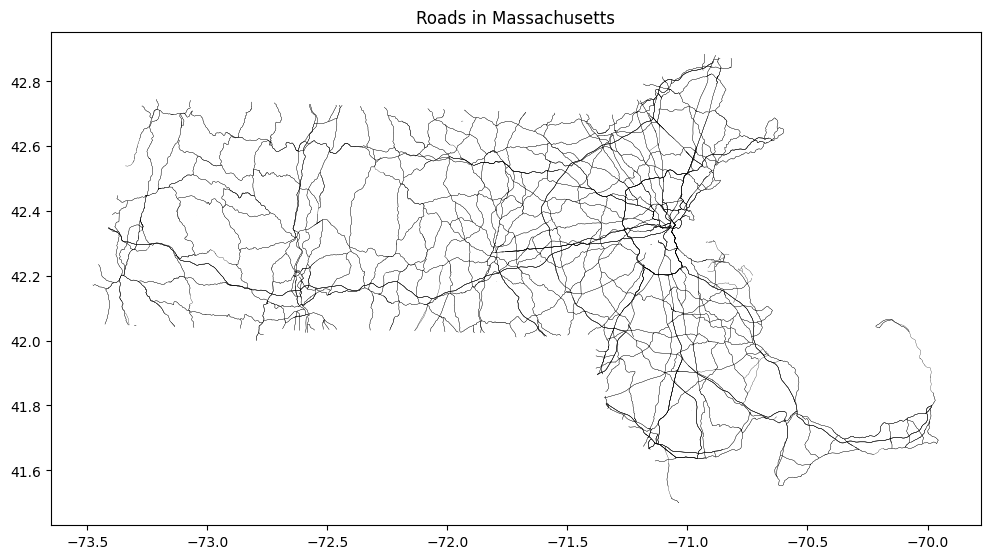

In [76]:
f, ax = plt.subplots(figsize=(12, 12))

# Plot the roads
gdf.plot(ax=ax, color='black', linewidth=0.2)

# Add a title
ax.set_title("Roads in Massachusetts")


Text(0, 0.5, 'Count (linear scale)')

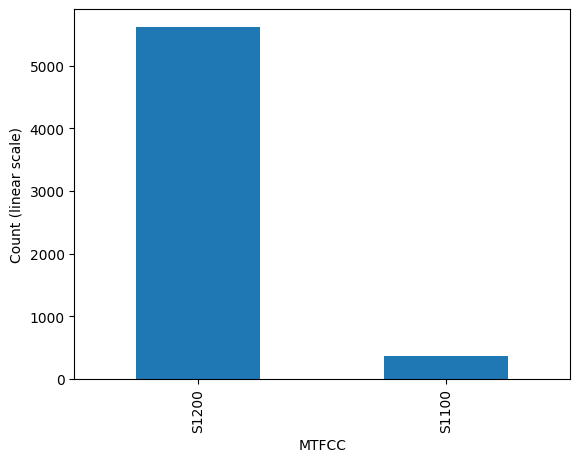

In [77]:
gdf['MTFCC'].value_counts().plot(kind="bar")
plt.xlabel('MTFCC')
plt.ylabel('Count (linear scale)')

Text(0, 0.5, 'Count (log scale)')

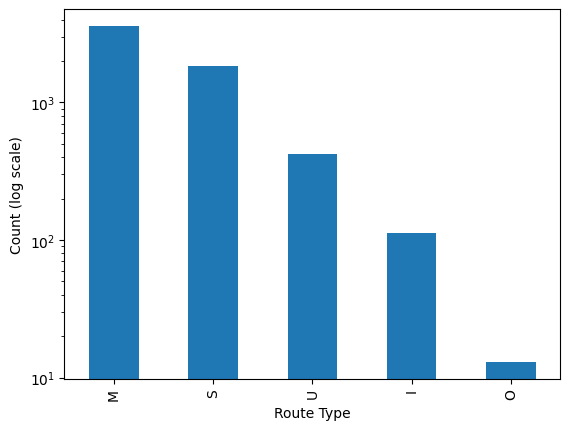

In [78]:
gdf['RTTYP'].value_counts().plot(kind="bar",logy=True)
plt.xlabel('Route Type')
plt.ylabel('Count (log scale)')

## Export to GeoJson format

In [79]:
gdf.to_file("roads.geojson", driver="GeoJSON")

# Part 2 - Area data (2D)

In [80]:
# Read the shapefile into a GeoDataFrame
us_counties_shapefile_path = "shape/us_county2022.zip"
gdf_counties = gpd.read_file(us_counties_shapefile_path)

In [81]:
gdf_counties.head(3)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,NaN,NaN,NaN,A,1477644346,10691216,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,NaN,NaN,NaN,A,680980770,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,NaN,NaN,NaN,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."


Text(0.5, 1.0, 'US Counties')

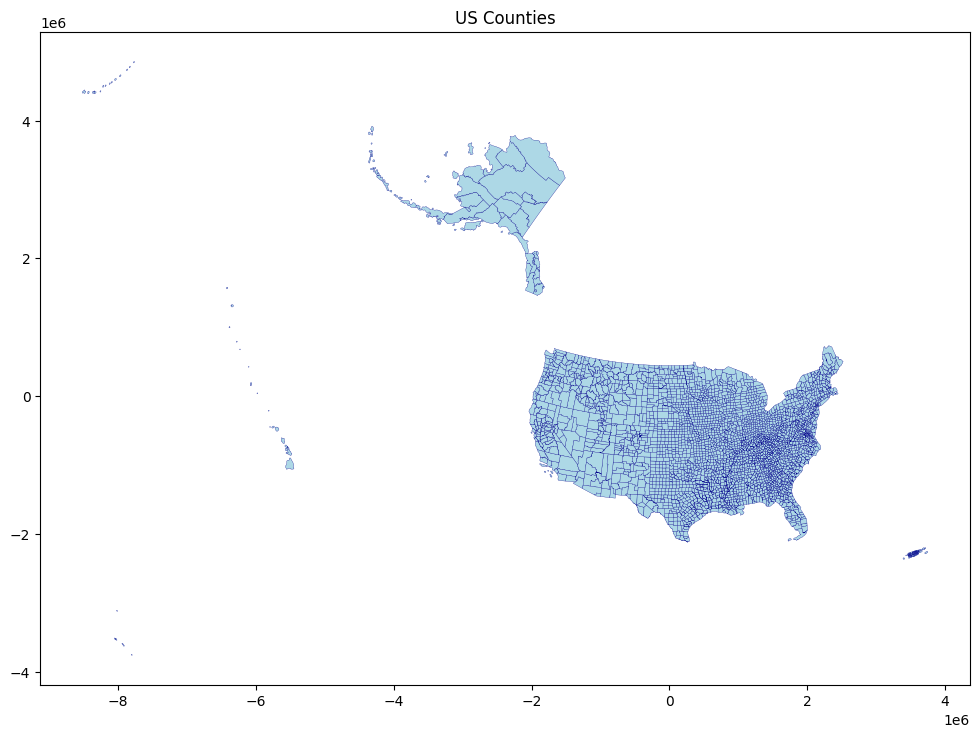

In [82]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the roads
gdf_counties.to_crs(2163).plot(ax=ax, color='lightblue', linewidth=0.2,edgecolor='darkblue')

# Add a title
ax.set_title("US Counties")

## Export to GeoJson Format
Note that the size of the file ie mainly related the to details of the polygons. If exported as is, the size of GeoJson file will be <font color=red>around 210 MegaBytes
</font><br>
#### to address this issue we can simplify the polygons


`https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.simplify.html`
"tolerance
float
All parts of a simplified geometry will be no more than tolerance distance from the original. It has the same units as the coordinate reference system of the GeoSeries. For example, using tolerance=100 in a projected CRS with meters as units means a distance of 100 meters in reality.

preserve_topology: bool (default True)
False uses a quicker algorithm, but may produce self-intersecting or otherwise invalid geometries."

In [83]:
gdf_counties.to_file("counties.geojson", driver="GeoJSON")

### Export into Topo json format.

In [90]:
topo = Topology(gdf_counties).to_json()
with open('counties.topojson','w') as f:
    json.dump(topo,f)

### Using the simplify function, I have reduced the file size to 1.1 MB which is 200 times smaller in size

In [84]:
tolerance = .05  # Adjust to have the suitable size

# Simplify the polygons in the GeoDataFrame
gdf_simplified = gdf_counties.simplify(tolerance,preserve_topology=True)

## Simplify by nature, <font color=red>removes the other properties</font> from the dataset. To return them back we can use the following

In [120]:
tolerance = .1

gdf_counties_simplified = gdf_counties.simplify(tolerance,preserve_topology=True)

## The simplified version will lose the properties.

## We can return them using this trick:

gdf_counties_simplified_withProps = gpd.GeoDataFrame(geometry=gdf_counties_simplified, crs=gdf_rivers.crs)

gdf_counties_simplified_withProps[gdf_rivers.columns[:-1]] = gdf_rivers[gdf_rivers.columns[:-1]]



gdf_counties_simplified_withProps.to_file("counties_smplf.geojson", driver="GeoJSON")

# We can also export data in the form of topojson

In [135]:
topo = json.loads(Topology(gdf_simplified).to_json(indent=2))
output_file = 'counties_smplf.topojson'
with open(output_file, 'w') as f:
    f.write(json.dumps(topo))

Text(0.5, 1.0, 'US Counties')

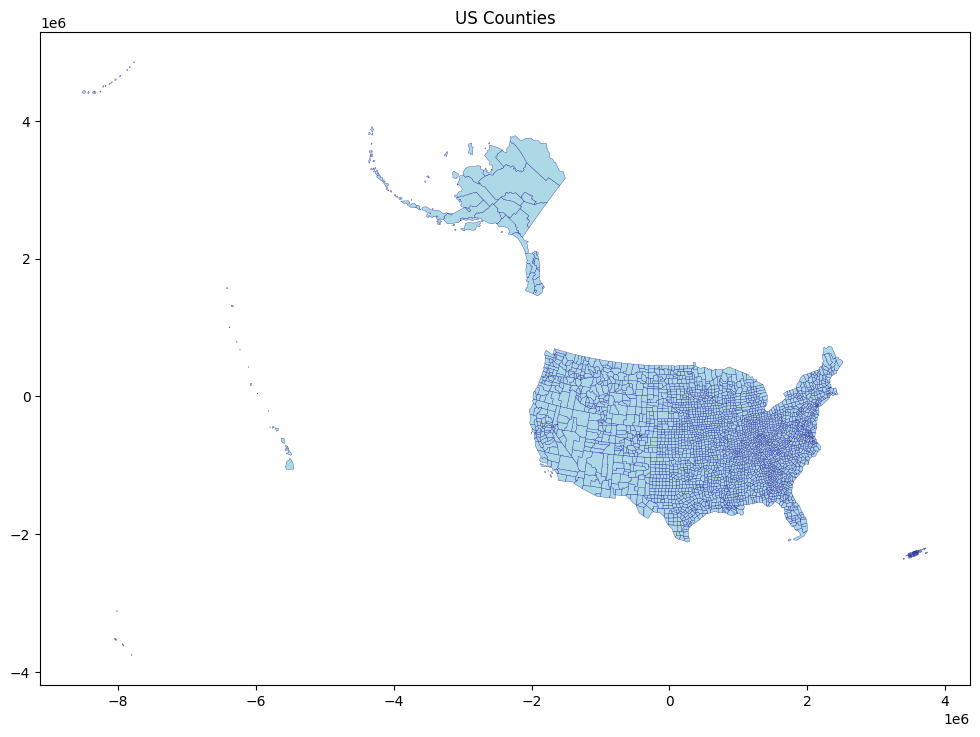

In [123]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the roads
gdf_counties_simplified_withProps.to_crs(2163).plot(ax=ax, color='lightblue', linewidth=0.2,edgecolor='darkblue')

# Add a title
ax.set_title("US Counties")